In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def get_file_trades(day):
    fname = f"../data/round1/trades_round_1_day_{day}_nn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round1/prices_round_1_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

In [3]:
# parameters

_symbol = "BANANAS"
# _day_ind = -2
_day_range = [-2, -1, 0]
_book_range = list(range(1, 3+1))
_max_time = 1000000

In [4]:
# get data for each day
trades = []
prices = []

for day in _day_range:
    # get data from files
    trade_df = get_file_trades(day)
    price_df = get_file_prices(day)
    
    trade_df["day"] = day
    
    trades += [trade_df]
    prices += [price_df]

# concat all data
trade_df = pd.concat(trades)
price_df = pd.concat(prices)

# reset indexes
trade_df = trade_df.reset_index(drop=True)
price_df = price_df.reset_index(drop=True)


# print columns that we believe to be irrelevant
# currency - SEASHELLS only
# buyer - nan only
# seller - nan only
display(trade_df["currency"].value_counts())
display(trade_df["buyer"].value_counts())
display(trade_df["seller"].value_counts())

# drop irrelevant columns
trade_df = trade_df.drop(["currency", "buyer", "seller"], axis=1)

# rename columns
price_df = price_df.rename({"product": "symbol"}, axis=1)
price_df = price_df.rename({"timestamp": "time"}, axis=1)

trade_df = trade_df.rename({"timestamp": "time"}, axis=1)

# filter for specific symbol
trade_df = trade_df[trade_df["symbol"] == _symbol]
price_df = price_df[price_df["symbol"] == _symbol]

# calculate new time (for multiday)
trade_df["time"] = trade_df["time"] + (trade_df["day"] - min(_day_range)) * _max_time
price_df["time"] = price_df["time"] + (price_df["day"] - min(_day_range)) * _max_time

# rename "bid" to "buy"
# rename "ask" to "sell"
price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)


fname ../data/round1/trades_round_1_day_-2_nn.csv
fname ../data/round1/prices_round_1_day_-2.csv
fname ../data/round1/trades_round_1_day_-1_nn.csv
fname ../data/round1/prices_round_1_day_-1.csv
fname ../data/round1/trades_round_1_day_0_nn.csv
fname ../data/round1/prices_round_1_day_0.csv


SEASHELLS    15786
Name: currency, dtype: int64

Series([], Name: buyer, dtype: int64)

Series([], Name: seller, dtype: int64)

In [5]:
def get_book_large_size(side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df

In [6]:
# get big buy/sell quotes
buy_df = get_book_large_size("buy")
sell_df = get_book_large_size("sell")

# create big quote_df
quote_df = pd.merge(buy_df, sell_df, on="time")
quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2

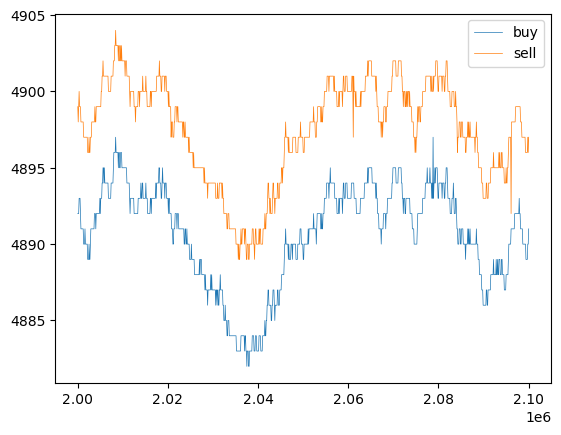

In [7]:
lb, ub = 2e6, 2e6+1e5
quote_df = quote_df[lb <= quote_df["time"]]
quote_df = quote_df[quote_df["time"] <= ub]

plt.plot(quote_df["time"], quote_df["buy_price"], linewidth=0.5, label="buy")
plt.plot(quote_df["time"], quote_df["sell_price"], linewidth=0.5, label="sell")

plt.legend()

(array([  2.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         41.,  60., 184., 114., 185.,  84., 171.,  82.,  76.]),
 array([ 3.  ,  4.45,  5.9 ,  7.35,  8.8 , 10.25, 11.7 , 13.15, 14.6 ,
        16.05, 17.5 , 18.95, 20.4 , 21.85, 23.3 , 24.75, 26.2 , 27.65,
        29.1 , 30.55, 32.  ]),
 <BarContainer object of 20 artists>)

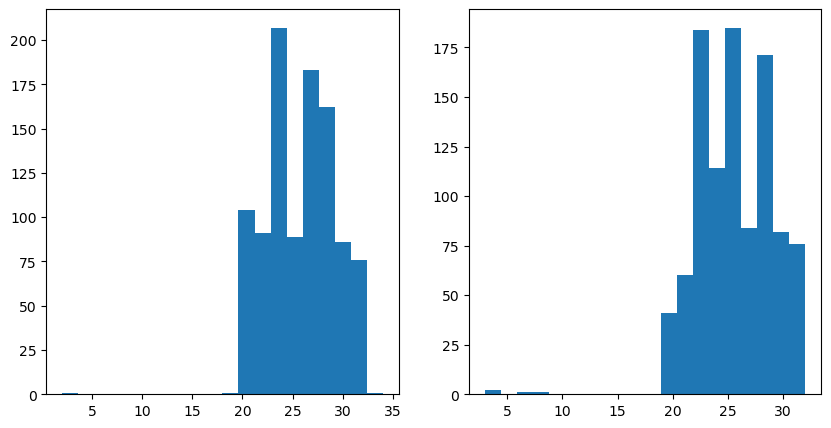

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(quote_df["buy_size"], bins=20)

plt.subplot(122)
plt.hist(quote_df["sell_size"], bins=20)

In [9]:
# diffs
diffs = quote_df["mid_price"] - quote_df["mid_price"].shift(1)
diffs = diffs.dropna()
diffs

20001   -0.5
20002    0.5
20003    1.0
20004   -0.5
20005    0.0
        ... 
20996    0.0
20997    0.0
20998    1.0
20999   -0.5
21000    1.0
Name: mid_price, Length: 1000, dtype: float64

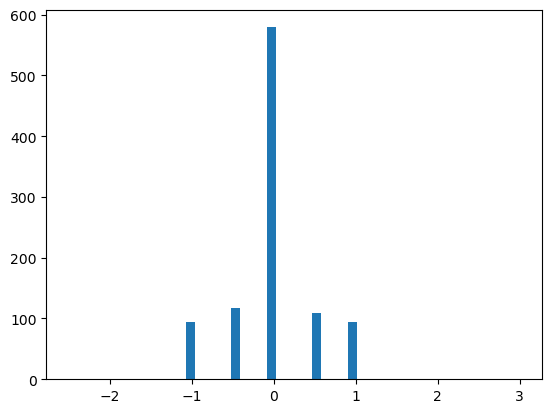

,count,mean,std,min,25%,50%,75%,max
mid_price,1000.0,-0.0015,0.526807,-2.5,0.0,0.0,0.0,3.0


std size 16.659089869355828
total change -1.5
z-score -0.09004093331408397


In [10]:
_ = plt.hist(diffs, bins=50)
plt.show()

diff_desc = pd.DataFrame(diffs).describe().T
display(diff_desc)

stdev = np.sqrt(len(diffs))* diff_desc["std"].iloc[0]
print("std size", stdev)
print("total change", diffs.sum())
print("z-score", diffs.sum() / stdev)

In [11]:
from sklearn.linear_model import LinearRegression

In [13]:
_turn_diffs = [-1, -10]
_pred_diff = 1

data = []

# get input data
for diff in _turn_diffs:
    data += [quote_df["mid_price"] - quote_df["mid_price"].shift(-1 * diff)]

# get output data
data += [quote_df["mid_price"].shift(-1 * _pred_diff) - quote_df["mid_price"]]

# form X, y - clean data
X = pd.concat(data, axis=1)
X = X.dropna()
X.columns = [f"d_{diff}" for diff in [*_turn_diffs, 1]]

y = X[[f"d_{_pred_diff}"]]
X = X.drop(f"d_{_pred_diff}", axis=1)

In [14]:
display(X)
display(y)


,d_-1,d_-10
20010,0.0,-1.0
20011,0.0,-0.5
20012,0.0,-1.0
20013,-1.0,-3.0
20014,0.0,-2.5
...,...,...
20995,0.0,-1.5
20996,0.0,-1.5
20997,0.0,-1.0
20998,1.0,0.0


,d_1
20010,0.0
20011,0.0
20012,-1.0
20013,0.0
20014,0.0
...,...
20995,0.0
20996,0.0
20997,1.0
20998,-0.5


In [15]:
reg = LinearRegression().fit(X, y)
display(reg.coef_)
display(reg.intercept_)

array([[-0.22714164, -0.00896936]])

array([-0.00106211])

In [16]:
print("coeffs", sum(reg.coef_))
print("intercept", sum(reg.intercept_))
print("score", reg.score(X, y))

coeffs [-0.22714164 -0.00896936]
intercept -0.0010621135410736609
score 0.055084455411894884
